<img style="float: left;;" src='Figures/iteso.jpg' width="100" height="200"/></a>

# <center> <font color= #000047>Aplicando Python para análisis de precios: simulación de escenarios futuros de precios</font> </center>




<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
# Importamos librerías
from pandas_datareader import data as web
import pandas as pd
import numpy as np
import yfinance


In [2]:
yfinance.pdr_override()

In [3]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(tickers, start_date=None, end_date=None):
    closes = web.get_data_yahoo(tickers, start=start_date, end = end_date, interval ='1d')['Adj Close']
    closes = closes.sort_index()
    return closes

In [4]:
# Descargamos datos...
# Instrumento: Apple
name = ['AAPL', 'WMT']
start = '2010-01-01'
end = '2023-01-01'
# Función para descargar los datos
closes = get_closes(tickers=name, start_date=start, end_date=end)

[*********************100%***********************]  2 of 2 completed


In [11]:
closes.head()

,AAPL,WMT
Date,,
2010-01-04,6.496294,40.013054
2010-01-05,6.507524,39.614639
2010-01-06,6.404015,39.526093
2010-01-07,6.392177,39.548225
2010-01-08,6.434672,39.349003


<AxesSubplot:xlabel='Date'>

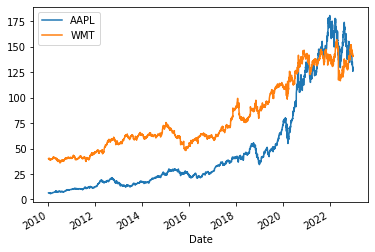

In [12]:
closes.plot()

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [16]:
ret = closes.pct_change().dropna()

In [18]:
ret.head()

,AAPL,WMT
Date,,
2010-01-05,0.001729,-0.009957
2010-01-06,-0.015906,-0.002235
2010-01-07,-0.001848,0.000560
2010-01-08,0.006648,-0.005037
2010-01-11,-0.008821,0.016501


In [19]:
ret.shape

(3271, 2)

In [20]:
len(ret)

3271

<AxesSubplot:xlabel='Date'>

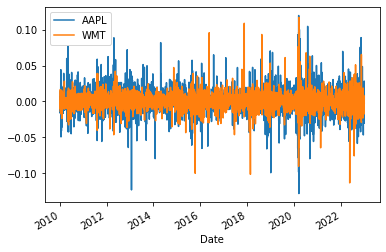

In [21]:
ret.plot()

Entonces, suponemos que la diferencia logaritmica de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [24]:
# Calculamos media y desviación estándar
mu = ret.mean()
mu

AAPL    0.001079
WMT     0.000460
dtype: float64

In [26]:
std = ret.std()
std

AAPL    0.018089
WMT     0.012301
dtype: float64

In [28]:
from matplotlib import pyplot as plt

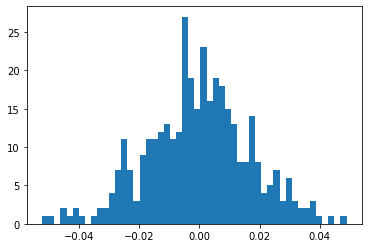

In [29]:
sim = np.random.normal(mu['AAPL'], std['AAPL'], size=365)
H = plt.hist(sim,bins=50)

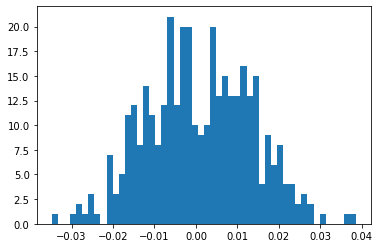

In [30]:
sim = np.random.normal(mu['WMT'], std['WMT'], size=365)
H = plt.hist(sim,bins=50)

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2010 - 2023, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el >2023-01 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios rendimientos diarios y que devuelva un dataframe con esta simulación.

In [31]:
pd.date_range('2023-03-25', periods = 5)

DatetimeIndex(['2023-03-25', '2023-03-26', '2023-03-27', '2023-03-28',
               '2023-03-29'],
              dtype='datetime64[ns]', freq='D')

In [32]:
# Ayuda en la función np.random.randn
help(np.random.randn)

Help on built-in function randn:

randn(...) method of numpy.random.mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    .. note::
        This is a convenience function for users porting code from Matlab,
        and wraps `standard_normal`. That function takes a
        tuple to specify the size of the output, which is consistent with
        other NumPy functions like `numpy.zeros` and `numpy.ones`.
    
    .. note::
        New code should use the ``standard_normal`` method of a ``default_rng()``
        instance instead; please see the :ref:`random-quick-start`.
    
    If positive int_like arguments are provided, `randn` generates an array
    of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1. A single float randomly sampled
    from the distribution is returned if no argument is provided.
 

In [33]:
# Función que simula varios escenarios de rendimientos diarios
def simular(mu, std, start, ndays, N):
    rango = pd.date_range(start, periods=ndays)
    return pd.DataFrame(index=rango, data = np.random.normal(mu,std,size=(ndays,N)))


In [34]:
ret.head()

,AAPL,WMT
Date,,
2010-01-05,0.001729,-0.009957
2010-01-06,-0.015906,-0.002235
2010-01-07,-0.001848,0.000560
2010-01-08,0.006648,-0.005037
2010-01-11,-0.008821,0.016501


In [35]:
ret.tail()

,AAPL,WMT
Date,,
2022-12-23,-0.002798,0.002021
2022-12-27,-0.013878,0.000278
2022-12-28,-0.030685,-0.017523
2022-12-29,0.028324,0.006087
2022-12-30,0.002469,-0.002533


In [36]:
mu = ret.mean()
std = ret.std()

In [37]:
mu

AAPL    0.001079
WMT     0.000460
dtype: float64

In [38]:
std

AAPL    0.018089
WMT     0.012301
dtype: float64

In [42]:
# Simulamos 100 escenarios para todo el 2023 Apple
N=100
simAPPL = simular(mu['AAPL'],std['AAPL'],'2023-01-01',365,N)
simAPPL

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2023-01-01,-0.019604,-0.005818,0.002636,0.021259,-0.015002,0.017601,0.015369,0.008513,-0.005967,0.013277,...,-0.004427,0.005008,-0.002862,-0.019554,0.009254,0.003191,0.004959,-0.016355,0.002577,-0.005765
2023-01-02,-0.021261,-0.011691,0.036796,0.018278,0.031321,-0.004412,-0.006412,-0.020104,-0.020073,0.001866,...,0.019455,0.020469,0.005449,0.046026,-0.013246,-0.036885,0.005199,0.025490,0.025198,-0.042464
2023-01-03,0.018835,-0.017416,-0.026059,0.014438,0.007083,-0.021504,-0.014032,0.002827,-0.000541,0.015430,...,-0.008057,0.026830,-0.005267,-0.018755,0.003455,-0.021257,-0.040608,-0.004540,-0.028035,-0.001192
2023-01-04,0.006360,0.015490,0.029164,-0.026990,-0.006989,-0.002754,-0.053926,0.003973,-0.003755,-0.036019,...,0.018387,0.014091,-0.000197,0.025665,0.019306,-0.014222,-0.022060,0.022068,0.021467,0.016113
2023-01-05,0.005642,0.011889,-0.016742,-0.002820,-0.013379,0.017576,-0.012293,-0.008203,0.001771,-0.008156,...,-0.006291,0.018988,-0.019767,0.009086,-0.007393,0.000110,-0.012205,0.012778,0.003094,0.009504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,-0.019570,-0.004453,-0.002318,-0.004100,0.007517,-0.007495,0.011153,-0.006769,-0.021430,-0.016402,...,0.015847,-0.009972,0.031059,-0.016225,-0.015177,-0.020053,-0.015421,0.030243,-0.014032,0.006658
2023-12-28,0.010461,-0.035499,-0.004369,0.019445,0.016902,-0.009455,-0.002932,-0.008832,0.009443,0.029406,...,0.005607,-0.011118,0.041870,0.016130,0.000941,0.008589,0.008600,0.020542,-0.020846,0.007293
2023-12-29,-0.016244,-0.009258,0.008986,0.019256,0.028354,0.011504,0.005621,-0.001758,-0.024222,0.018879,...,-0.041664,0.006446,-0.024608,0.002540,-0.022286,0.007676,0.006146,-0.014554,0.028636,0.010715
2023-12-30,0.059856,-0.004102,0.015070,0.010750,-0.012242,-0.014359,0.016607,0.004119,0.000266,-0.000132,...,0.005828,-0.023837,-0.031818,-0.005351,-0.010414,-0.013027,0.016661,-0.012558,0.001644,-0.011947


<AxesSubplot:>

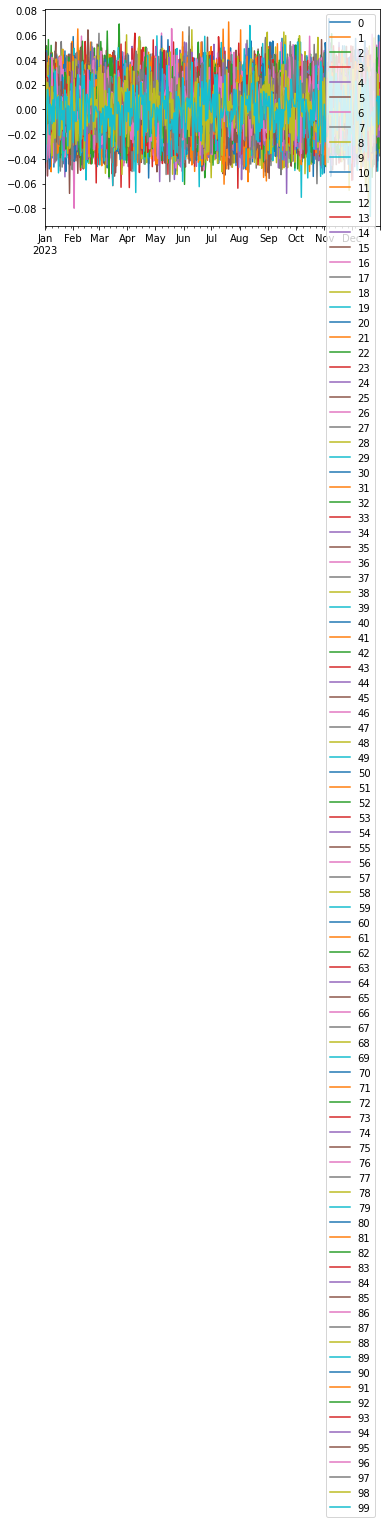

In [43]:
simAPPL.plot()

array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>]], dtype=object)

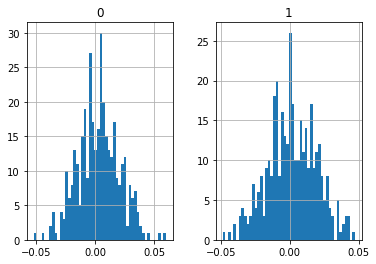

In [45]:
simAPPL[[0,1]].hist(bins=50)

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}\exp(r_0+\cdots+r_{k})$, donde $p_{-1}$ es el último precio reportado en el 2022.

Con los rendimientos, calculamos los precios de cierre...

In [49]:
simAPPL[1].cumprod()

2023-01-01   -5.818325e-03
2023-01-02    6.802211e-05
2023-01-03   -1.184644e-06
2023-01-04   -1.834982e-08
2023-01-05   -2.181644e-10
                  ...     
2023-12-27   -0.000000e+00
2023-12-28    0.000000e+00
2023-12-29   -0.000000e+00
2023-12-30    0.000000e+00
2023-12-31   -0.000000e+00
Freq: D, Name: 1, Length: 365, dtype: float64

In [50]:
help(pd.DataFrame.cumprod)

Help on function cumprod in module pandas.core.generic:

cumprod(self, axis=None, skipna=True, *args, **kwargs)
    Return cumulative product over a DataFrame or Series axis.
    
    Returns a DataFrame or Series of the same size containing the cumulative
    product.
    
    Parameters
    ----------
    axis : {0 or 'index', 1 or 'columns'}, default 0
        The index or the name of the axis. 0 is equivalent to None or 'index'.
    skipna : bool, default True
        Exclude NA/null values. If an entire row/column is NA, the result
        will be NA.
    *args, **kwargs
        Additional keywords have no effect but might be accepted for
        compatibility with NumPy.
    
    Returns
    -------
    Series or DataFrame
        Return cumulative product of Series or DataFrame.
    
    See Also
    --------
    core.window.Expanding.prod : Similar functionality
        but ignores ``NaN`` values.
    DataFrame.prod : Return the product over
        DataFrame axis.
    DataFram

In [53]:
# Obtenemos los precios
closes.tail()

,AAPL,WMT
Date,,
2022-12-23,131.477127,142.641281
2022-12-27,129.652435,142.680969
2022-12-28,125.674026,140.180740
2022-12-29,129.233658,141.033997
2022-12-30,129.552719,140.676819


In [54]:
closes['AAPL'][-1]

129.55271911621094

$$p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1)$$

In [55]:
AAPL = closes['AAPL'][-1]*(simAPPL + 1).cumprod()

In [56]:
AAPL

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2023-01-01,127.012961,128.798939,129.894246,132.306840,127.609148,131.832936,131.543867,130.655588,128.779733,131.272744,...,128.979168,130.201568,129.181889,127.019467,130.751649,129.966152,130.195216,127.433830,129.886588,128.805822
2023-01-02,124.312576,127.293149,134.673778,134.725187,131.606004,131.251328,130.700396,128.028836,126.194730,131.517737,...,131.488403,132.866719,129.885757,132.865617,129.019761,125.172384,130.872105,130.682127,133.159408,123.336225
2023-01-03,126.653999,125.076267,131.164347,136.670387,132.538204,128.428957,128.866396,128.390755,126.126500,133.547066,...,130.429040,136.431512,129.201649,130.373775,129.465556,122.511633,125.557654,130.088841,129.426341,123.189168
2023-01-04,127.459544,127.013665,134.989646,132.981658,131.611926,128.075215,121.917209,128.900832,125.652945,128.736853,...,132.827204,138.353930,129.176177,133.719811,131.965051,120.769319,122.787806,132.959662,132.204685,125.174146
2023-01-05,128.178677,128.523754,132.729682,132.606656,129.851049,130.326234,120.418499,127.843462,125.875508,127.686930,...,131.991588,140.980978,126.622750,134.934749,130.989459,120.782556,121.289187,134.658639,132.613784,126.363857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,323.843549,237.073010,194.703824,169.370951,122.139326,126.284542,180.975839,209.189566,170.034092,187.834480,...,202.999827,131.271828,153.168761,200.959431,166.252519,226.699809,309.026067,206.543990,126.216672,91.584497
2023-12-28,327.231354,228.657201,193.853189,172.664372,124.203723,125.090468,180.445164,207.341993,171.639750,193.357990,...,204.138136,129.812284,159.581933,204.200964,166.408891,228.646888,311.683600,210.786888,123.585538,92.252414
2023-12-29,321.915726,226.540221,195.595202,175.989145,127.725342,126.529467,181.459403,206.977490,167.482287,197.008387,...,195.632961,130.649058,155.654979,204.719640,162.700300,230.401922,313.599273,207.719032,127.124564,93.240917
2023-12-30,341.184266,225.611057,198.542818,177.881062,126.161702,124.712581,184.472817,207.830027,167.526847,196.982367,...,196.773104,127.534820,150.702347,203.624144,161.005991,227.400483,318.824094,205.110596,127.333583,92.126955


<AxesSubplot:>

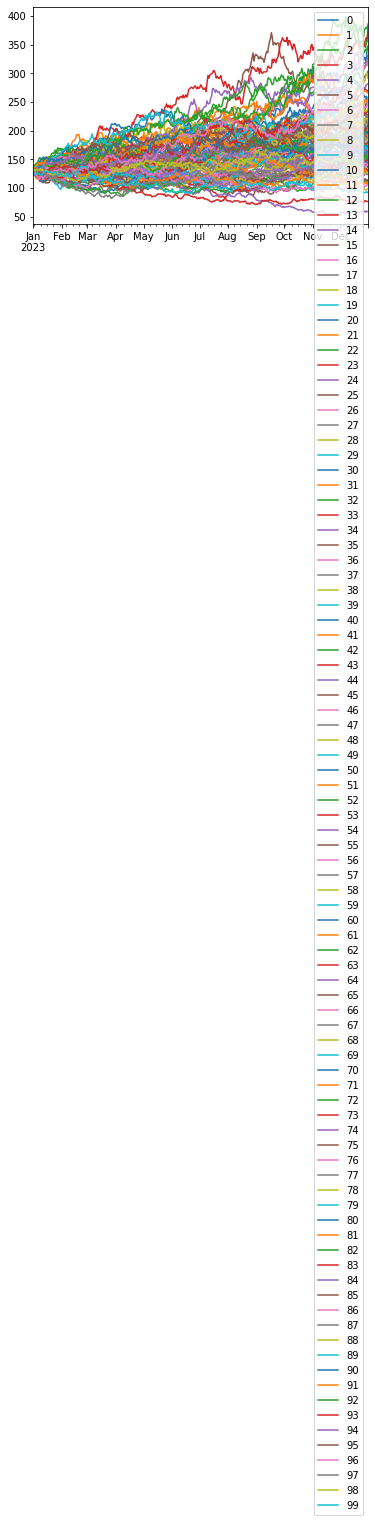

In [59]:
AAPL.plot()

<AxesSubplot:>

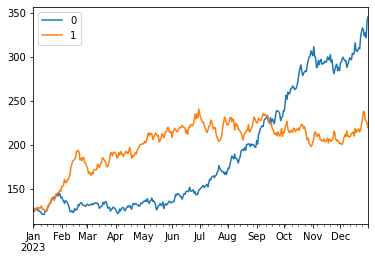

In [58]:
AAPL[[0,1]].plot()

Concatenamos y graficamos...

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [60]:
closes['AAPL'][-1]

129.55271911621094

In [61]:
umbral = closes['AAPL'][-1]*1.2 # Retorno del 20%
umbral

155.46326293945313

In [62]:
# Umbral de 10% del ultimo precio
umbral = closes['AAPL'][-1]*1.1 # Retorno del 10%
umbral


142.50799102783205

In [68]:
rango = pd.date_range('2023-01-01', periods = 365)
Umbral_df = pd.DataFrame(data=umbral*np.ones(365), index = rango, columns =['umbral'])
AAPL_umbral = pd.concat([AAPL,Umbral_df], axis=1)


In [69]:
AAPL_umbral

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,umbral
2023-01-01,127.012961,128.798939,129.894246,132.306840,127.609148,131.832936,131.543867,130.655588,128.779733,131.272744,...,130.201568,129.181889,127.019467,130.751649,129.966152,130.195216,127.433830,129.886588,128.805822,142.507991
2023-01-02,124.312576,127.293149,134.673778,134.725187,131.606004,131.251328,130.700396,128.028836,126.194730,131.517737,...,132.866719,129.885757,132.865617,129.019761,125.172384,130.872105,130.682127,133.159408,123.336225,142.507991
2023-01-03,126.653999,125.076267,131.164347,136.670387,132.538204,128.428957,128.866396,128.390755,126.126500,133.547066,...,136.431512,129.201649,130.373775,129.465556,122.511633,125.557654,130.088841,129.426341,123.189168,142.507991
2023-01-04,127.459544,127.013665,134.989646,132.981658,131.611926,128.075215,121.917209,128.900832,125.652945,128.736853,...,138.353930,129.176177,133.719811,131.965051,120.769319,122.787806,132.959662,132.204685,125.174146,142.507991
2023-01-05,128.178677,128.523754,132.729682,132.606656,129.851049,130.326234,120.418499,127.843462,125.875508,127.686930,...,140.980978,126.622750,134.934749,130.989459,120.782556,121.289187,134.658639,132.613784,126.363857,142.507991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,323.843549,237.073010,194.703824,169.370951,122.139326,126.284542,180.975839,209.189566,170.034092,187.834480,...,131.271828,153.168761,200.959431,166.252519,226.699809,309.026067,206.543990,126.216672,91.584497,142.507991
2023-12-28,327.231354,228.657201,193.853189,172.664372,124.203723,125.090468,180.445164,207.341993,171.639750,193.357990,...,129.812284,159.581933,204.200964,166.408891,228.646888,311.683600,210.786888,123.585538,92.252414,142.507991
2023-12-29,321.915726,226.540221,195.595202,175.989145,127.725342,126.529467,181.459403,206.977490,167.482287,197.008387,...,130.649058,155.654979,204.719640,162.700300,230.401922,313.599273,207.719032,127.124564,93.240917,142.507991
2023-12-30,341.184266,225.611057,198.542818,177.881062,126.161702,124.712581,184.472817,207.830027,167.526847,196.982367,...,127.534820,150.702347,203.624144,161.005991,227.400483,318.824094,205.110596,127.333583,92.126955,142.507991


<AxesSubplot:>

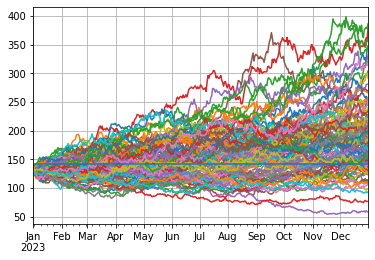

In [70]:
AAPL_umbral.plot(legend=False, grid=True)

In [71]:
prob = AAPL > umbral
prob

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2023-01-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2023-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,True,True,True,True,False,False,True,True,True,True,...,True,False,True,True,True,True,True,True,False,False
2023-12-28,True,True,True,True,False,False,True,True,True,True,...,True,False,True,True,True,True,True,True,False,False
2023-12-29,True,True,True,True,False,False,True,True,True,True,...,True,False,True,True,True,True,True,True,False,False
2023-12-30,True,True,True,True,False,False,True,True,True,True,...,True,False,True,True,True,True,True,True,False,False


<AxesSubplot:>

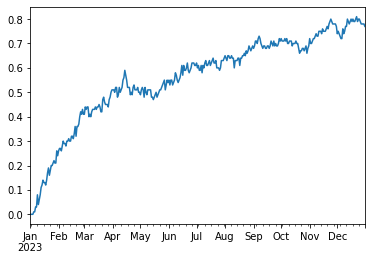

In [73]:
np.mean(prob,axis=1).plot()

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

### Actividad:
Obtner la probabilidad precio umbral para Walmart.